# Tidy Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 6
pd.options.display.max_columns = 6

/Users/jreback/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Structuring datasets to facilitate analysis [(Wickham 2014)](http://www.jstatsoft.org/v59/i10/paper)

If there's one maxim I can impart it's that your tools shouldn't get in the way of your analysis. Your problem is already difficult enough, don't let the data or your tools make it any harder.

In a tidy dataset...

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We'll cover a few methods that help you get there.

In [3]:
tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2015_games.html")
games = tables[0]
games.to_csv('data/games.csv', index=False)

In [5]:
!head -n 5 data/games.csv

Date,Start (ET),Unnamed: 2,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 7,Notes
October,,,,,,,,
"Tue, Oct 28, 2014",10:30 pm,Box Score,Houston Rockets,108.0,Los Angeles Lakers,90.0,,
"Tue, Oct 28, 2014",8:00 pm,Box Score,Orlando Magic,84.0,New Orleans Pelicans,101.0,,
"Tue, Oct 28, 2014",8:00 pm,Box Score,Dallas Mavericks,100.0,San Antonio Spurs,101.0,,


The Question:
> **How many days of rest did each team get between each game?**

Whether or not your dataset is tidy depends on your question. Given our question, what is an observation?

In [41]:
# parse and convert
column_names = ['date1', 'time', '_', 'away_team', 'away_points', 
                'home_team', 'home_points', 'n_ot', 'notes']
games = (pd.read_csv('data/games.csv', names=column_names, 
                      header=None, skiprows=2)
           .assign(date = lambda x: pd.to_datetime(x['date1'],
                                                   errors='coerce'))
           .drop(['_', 'date1', 'notes', 'n_ot'], axis='columns')
           .set_index('date', append=True)
        )
games.index.names = ['game_id', 'date']
games.head()         

,,time,away_team,away_points,home_team,home_points
game_id,date,,,,,
0,2014-10-28,10:30 pm,Houston Rockets,108,Los Angeles Lakers,90
1,2014-10-28,8:00 pm,Orlando Magic,84,New Orleans Pelicans,101
2,2014-10-28,8:00 pm,Dallas Mavericks,100,San Antonio Spurs,101
3,2014-10-29,7:30 pm,Brooklyn Nets,105,Boston Celtics,121
4,2014-10-29,7:00 pm,Milwaukee Bucks,106,Charlotte Hornets,108


Is `games` a tidy dataset, given our question? No, we have multiple observations (teams) per row. We'll use `pd.melt` to fix that.

In [42]:
tidy = pd.melt(games.sort_index().reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')

In [43]:
tidy.head()

,game_id,date,variable,team
0,0,2014-10-28,away_team,Houston Rockets
1,1,2014-10-28,away_team,Orlando Magic
2,2,2014-10-28,away_team,Dallas Mavericks
3,3,2014-10-29,away_team,Brooklyn Nets
4,4,2014-10-29,away_team,Milwaukee Bucks


In [21]:
games.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1230 entries, (0, 2014-10-28 00:00:00) to (1229, 2015-04-15 00:00:00)
Data columns (total 4 columns):
away_team      1230 non-null object
away_points    1230 non-null int64
home_team      1230 non-null object
home_points    1230 non-null int64
dtypes: int64(2), object(2)
memory usage: 54.2+ KB


In [22]:
tidy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 0 to 2459
Data columns (total 4 columns):
game_id     2460 non-null int64
date        2460 non-null datetime64[ns]
variable    2460 non-null object
team        2460 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 96.1+ KB


Now the translation from question to operation is direct:

In [23]:
tidy.head()

,game_id,date,variable,team
0,0,2014-10-28,away_team,Houston Rockets
1,1,2014-10-28,away_team,Orlando Magic
2,2,2014-10-28,away_team,Dallas Mavericks
3,3,2014-10-29,away_team,Brooklyn Nets
4,4,2014-10-29,away_team,Milwaukee Bucks


In [24]:
# For each team... get number of dates between games
tidy.groupby('team')['date'].diff().dt.days - 1

0      NaN
1      NaN
2      NaN
        ..
2457     4
2458     1
2459    10
dtype: float64

In [51]:
tidy['rest'] = (tidy
                    .sort_values('date')
                    .groupby('team')
                    .date.diff()
                    .dt
                    .days - 1
)
tidy.dropna()

,game_id,date,variable,team,rest
10,10,2014-10-29,away_team,Los Angeles Lakers,0
14,14,2014-10-29,away_team,Houston Rockets,0
15,15,2014-10-30,away_team,New York Knicks,0
...,...,...,...,...,...
2469,1233,2015-04-15,home_team,New York Knicks,1
2470,1234,2015-04-15,home_team,Philadelphia 76ers,1
2471,1235,2015-04-15,home_team,Toronto Raptors,0


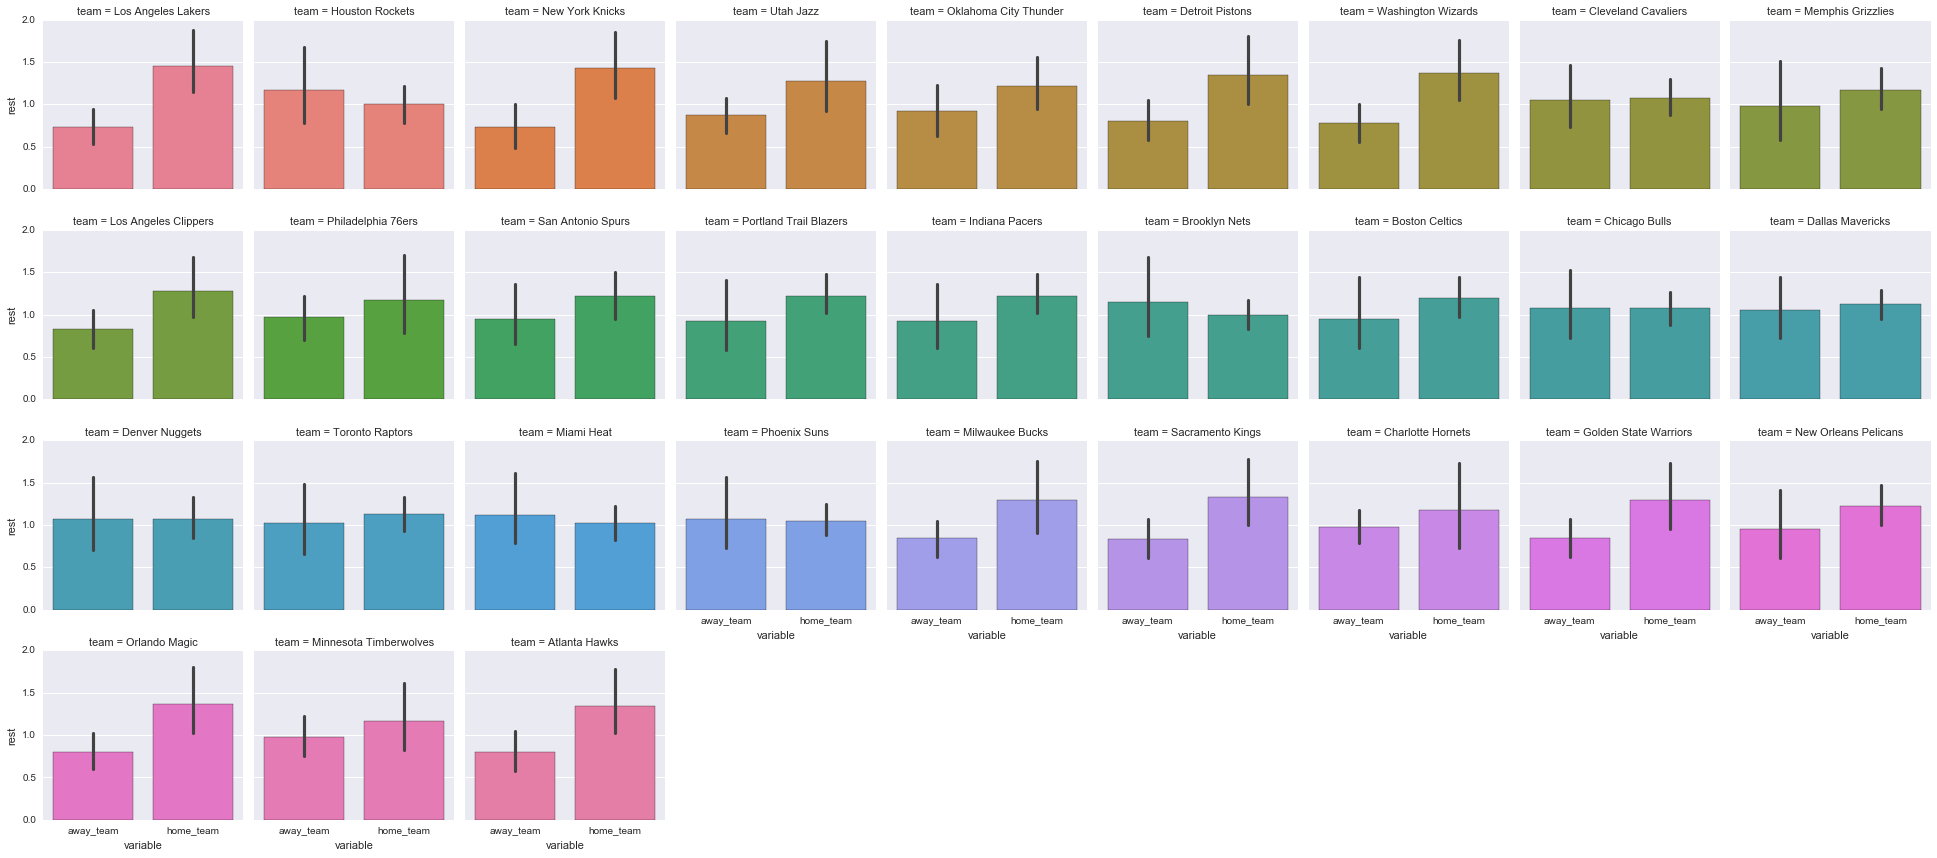

In [54]:
(tidy.dropna()
     .pipe(sns.FacetGrid, col='team', col_wrap=9, hue='team')
     .map(sns.barplot, "variable", "rest")
 )

What are we doing?

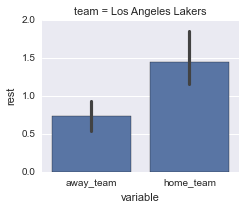

In [36]:
r = tidy.dropna()
r = r[r.team == 'Los Angeles Lakers']
g = sns.FacetGrid(data=r, col='team', col_wrap=5, hue='team')
g.map(sns.barplot, "variable", "rest");

In [37]:
g = r.groupby('variable')
g.rest.sum()/g.rest.count()

variable
away_team    0.731707
home_team    1.450000
Name: rest, dtype: float64

# Stack / Unstack

An "observation" depends on the question. Home team advantage?

('Home win percent:', 0.57200647249190939)


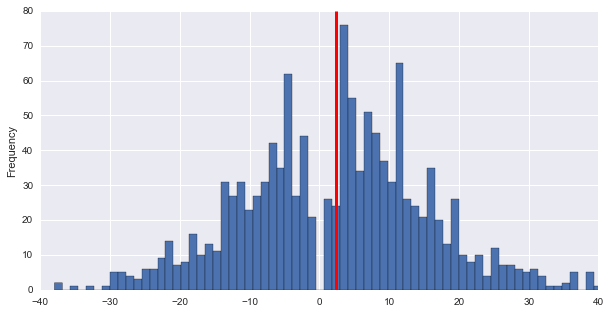

In [57]:
home_adv = games.home_points - games.away_points
ax = (home_adv).plot(kind='hist', bins=80, figsize=(10, 5))
ax.set_xlim(-40, 40)
mu = home_adv.mean()
ax.vlines(mu, *ax.get_ylim(), color='red', linewidth=3)
print('Home win percent:', (home_adv > 0).mean())

# Team Strength

### Mini Project: Home Court Advantage?

What's the effect (in terms of probability to win) of being
the home team.


### Step 1. Calculate Win %

We need to create an indicator for whether the home team won.
Add it as a column called `home_win` in `games`.

In [60]:
games['home_win'] = games['home_points'] > games['away_points']
games.head()

,,time,away_team,away_points,home_team,home_points,home_win
game_id,date,,,,,,
0,2014-10-28,10:30 pm,Houston Rockets,108,Los Angeles Lakers,90,False
1,2014-10-28,8:00 pm,Orlando Magic,84,New Orleans Pelicans,101,True
2,2014-10-28,8:00 pm,Dallas Mavericks,100,San Antonio Spurs,101,True
3,2014-10-29,7:30 pm,Brooklyn Nets,105,Boston Celtics,121,True
4,2014-10-29,7:00 pm,Milwaukee Bucks,106,Charlotte Hornets,108,True


### Step 2: Find the win percent for each team

Teams are split across two columns. It's easiest to calculate the number of wins and number of games as away, and the number of wins and number of games as home. Then combine those two results to get the win percent.

In [66]:
wins_as_away = games.groupby('away_team').home_win.agg(
    {'n_games': 'count', 'n_wins': lambda x: (~x).sum()}
)
wins_as_home = games.groupby('home_team').home_win.agg(
    {'n_games': 'count', 'n_wins': 'sum'}
)
wins = (wins_as_away + wins_as_home)
wins

,n_games,n_wins
away_team,,
Atlanta Hawks,82,60
Boston Celtics,82,40
Brooklyn Nets,82,38
...,...,...
Toronto Raptors,82,49
Utah Jazz,82,38
Washington Wizards,82,46


Finally, calculate the win percent.

In [64]:
strength = wins.n_wins / wins.n_games
strength.index.name = 'team'
strength.name = 'strength'

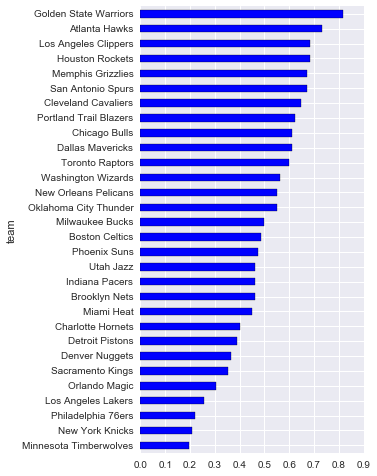

In [71]:
strength.sort_values().plot.barh(figsize=(4,8))

Bring the `strength` valuess in for each team, for each game.

In [19]:
games.head()

,,away_team,away_points,home_team,home_points,home_win
game_id,date,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,90,False
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,101,True
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,101,True
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,121,True
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,108,True


For SQL people

```sql
SELECT *
FROM games NATURAL JOIN strength
```

We just need to get the names worked out.

In [20]:
strength.head().reset_index().rename(columns=lambda x: 'away_' + x)

,away_team,away_strength
0,Atlanta Hawks,1.366667
1,Boston Celtics,2.050000
2,Brooklyn Nets,2.157895
3,Charlotte Hornets,2.484848
4,Chicago Bulls,1.640000


In [21]:
(pd.merge(games.reset_index(), strength.reset_index().add_prefix('away_'))
   .pipe(pd.merge, strength.reset_index().add_prefix('home_'))
   .set_index(['game_id', 'date']))

,,away_team,away_points,home_team,...,home_win,away_strength,home_strength
game_id,date,,,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,...,False,1.464286,3.904762
661,2015-01-25,Houston Rockets,99,Los Angeles Lakers,...,False,1.464286,3.904762
541,2015-01-09,Orlando Magic,84,Los Angeles Lakers,...,True,3.280000,3.904762
...,...,...,...,...,...,...,...,...
476,2014-12-31,Charlotte Hornets,83,Houston Rockets,...,True,2.484848,1.464286
380,2014-12-18,New Orleans Pelicans,99,Houston Rockets,...,False,1.822222,1.464286
1195,2015-04-12,New Orleans Pelicans,114,Houston Rockets,...,True,1.822222,1.464286


For python people

In [22]:
games = games.assign(away_strength=games.away_team.map(strength),
                     home_strength=games.home_team.map(strength))
games.head()

,,away_team,away_points,home_team,...,home_win,away_strength,home_strength
game_id,date,,,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,...,False,1.464286,3.904762
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,...,True,3.280000,1.822222
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,...,True,1.640000,1.490909
3,2014-10-29,Brooklyn Nets,105,Boston Celtics,...,True,2.157895,2.050000
4,2014-10-29,Milwaukee Bucks,106,Charlotte Hornets,...,True,2.000000,2.484848


# Pivoting

In [33]:
tidy

,game_id,date,variable,team,rest
0,0,2014-10-28,away_team,Houston Rockets,NaN
1,1,2014-10-28,away_team,Orlando Magic,NaN
2,2,2014-10-28,away_team,Dallas Mavericks,NaN
...,...,...,...,...,...
2457,1227,2015-04-15,home_team,New York Knicks,1
2458,1228,2015-04-15,home_team,Philadelphia 76ers,1
2459,1229,2015-04-15,home_team,Toronto Raptors,0


In [31]:
un = pd.pivot_table(tidy, values='rest',
                    index=['game_id', 'date'],
                    columns='variable').rename(
    columns={'away_team': 'away_rest', 'home_team': 'home_rest'}
)
un.columns.name = None

In [32]:
un.dropna().head()

,,away_rest,home_rest
game_id,date,,
16,2014-10-30,0,1
18,2014-10-30,0,0
19,2014-10-30,0,1
20,2014-10-31,0,1
21,2014-10-31,1,1


In [34]:
df = pd.concat([games, un], axis=1)
df

,,away_team,away_points,home_team,...,home_strength,away_rest,home_rest
game_id,date,,,,,,,
0,2014-10-28,Houston Rockets,108,Los Angeles Lakers,...,3.904762,NaN,NaN
1,2014-10-28,Orlando Magic,84,New Orleans Pelicans,...,1.822222,NaN,NaN
2,2014-10-28,Dallas Mavericks,100,San Antonio Spurs,...,1.490909,NaN,NaN
...,...,...,...,...,...,...,...,...
1227,2015-04-15,Detroit Pistons,112,New York Knicks,...,4.823529,1,1
1228,2015-04-15,Miami Heat,105,Philadelphia 76ers,...,4.555556,1,1
1229,2015-04-15,Charlotte Hornets,87,Toronto Raptors,...,1.673469,1,0


In [35]:
X = pd.concat([games, un], axis=1).set_index(['away_team', 'home_team'], append=True).dropna()

In [36]:
X.head()

,,,,away_points,home_points,home_win,...,home_strength,away_rest,home_rest
game_id,date,away_team,home_team,,,,,,,
16,2014-10-30,Utah Jazz,Dallas Mavericks,102,120,True,...,1.640000,0,1
18,2014-10-30,Detroit Pistons,Minnesota Timberwolves,91,97,True,...,5.125000,0,0
19,2014-10-30,Washington Wizards,Orlando Magic,105,98,False,...,3.280000,0,1
20,2014-10-31,Cleveland Cavaliers,Chicago Bulls,114,108,False,...,1.640000,0,1
21,2014-10-31,Memphis Grizzlies,Indiana Pacers,97,89,False,...,2.157895,1,1


In [1]:
X.to_hdf('data/games.hdf','df')

NameError: name 'X' is not defined

In [37]:
X['home_win'] = X.home_win.astype(int)  # for statsmodels

import statsmodels.api as sm

mod = sm.Logit.from_formula('home_win ~ home_strength + away_strength + home_rest + away_rest', X)
res = mod.fit()
res.summary()

mod = sm.Logit.from_formula('home_win ~ rest_difference',
                            X.assign(rest_difference=lambda df: df.home_rest - df.away_rest))
res = mod.fit()
res.summary()

mod = sm.OLS.from_formula('spread ~ home_strength + away_strength + rest_difference',
                            X.assign(rest_difference=lambda df: df.home_rest - df.away_rest,
                                     spread=lambda df: df.home_points - df.away_points))
res = mod.fit()
res.summary()

# Recap

- Tidy data: one row per observation
    - melt / stack: wide to long
    - pivot_table / unstack: long to wide